# Two Moons Simformer Conditional Flow Matching Example

This notebook demonstrates how to train and sample from a conditional flow-matching model on the Two Moons task using JAX and Flax. We cover environment setup, data generation, model definition, training, sampling, and evaluation.

## 1. Environment Setup

We set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage. This section also ensures compatibility with Google Colab.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [3]:
# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
import os
# os.environ['JAX_PLATFORMS']="cuda"
os.environ['JAX_PLATFORMS']="cpu"

In [4]:
experiment_id = 2

### Set Training and Model Restoration Flags

Configure whether to restore a pretrained model or train from scratch.

In [5]:
restore_model=True
train_model=False

### Set Checkpoint Directory

Specify the directory for saving and restoring model checkpoints.

In [6]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
# checkpoint_dir = f"/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_flow_simformer"
checkpoint_dir = f"/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/old/checkpoints/two_moons_simformer"
os.makedirs(checkpoint_dir, exist_ok=True)

## 2. Library Imports and JAX Mesh Setup

Import required libraries and set up the JAX mesh for sharding.

In [7]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np


/home/zaldivar/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Optimizer and Learning Rate Schedule Parameters

Define optimizer hyperparameters and learning rate scheduling.

## 4. Task and Dataset Setup

Define the Two Moons task and prepare training and validation datasets.

In [8]:
from gensbi.utils.plotting import plot_marginals

### Define the Task

In [9]:
from gensbi_examples.tasks import TwoMoons
task = TwoMoons()

./task_data/data_two_moons.npz already exists, skipping download.


In [10]:
obs, reference_samples = task.get_reference(num_observation=8)

#### Visualize Reference Samples

Plot the reference samples from the Two Moons task.

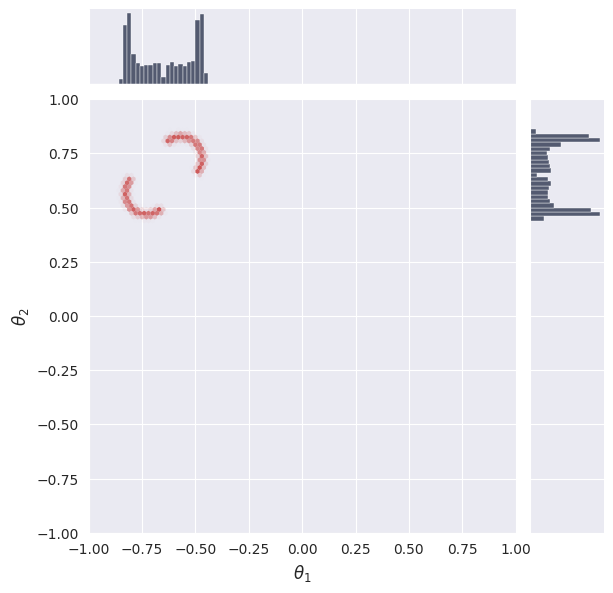

In [11]:
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=100,range=[(-1.,1.),(-1.,1.)], backend="seaborn", plot_levels=False)
plt.show()

## 5. Dataset Preparation

Create training and validation datasets for the model.

In [12]:
# make a dataset
nsamples = int(1e5)

In [13]:
batch_size = 32 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset()

dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

In [14]:
next(dataset_iter).shape, next(val_dataset_iter).shape

((32, 4, 1), (512, 4, 1))

## 6. Model Definition

Define the Simformer model and the conditional flow-matching loss.

**Note:**  
- The model uses *edge masks* as attention masks, which are crucial for controlling which variables are attended to during training and inference. These masks enable both posterior estimation (conditioning on observed data) and unconditional density estimation (no conditioning).
- The *marginalization* function is used to construct edge masks that marginalize out arbitrary variables, allowing the model to learn and evaluate arbitrary marginal distributions.

In [15]:
from gensbi.models import SimformerParams, Flux1Params
from gensbi.recipes import SimformerFlowPipeline, SimformerDiffusionPipeline, Flux1FlowPipeline, Flux1DiffusionPipeline

In [16]:
import yaml

config = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/config_flow_simformer.yaml"

# Load config
with open(config, "r") as f:
    config = yaml.safe_load(f)

In [17]:
dim_obs = task.dim_obs.item()
dim_cond = task.dim_cond.item()

dim_joint = task.dim_joint.item()
node_ids = jnp.arange(dim_joint)

In [18]:
train_params = config.get("training", {})
experiment_id = train_params.get("experiment_id", 3)
restore_model = train_params.get("restore_model", False)
train_model = train_params.get("train_model", True)
batch_size = train_params.get("batch_size", 4096)
nsteps = train_params.get("nsteps", 10000)
nepochs = train_params.get("nepochs", 3)
multistep = train_params.get("multistep", 1)
early_stopping = train_params.get("early_stopping", True)
print_every = train_params.get("print_every", 100)

In [19]:


# Optimizer parameters
opt_params = config.get("optimizer", {})
PATIENCE = opt_params.get("patience", 10)
COOLDOWN = opt_params.get("cooldown", 2)
FACTOR = opt_params.get("factor", 0.5)
ACCUMULATION_SIZE = opt_params.get("accumulation_size", 100)
RTOL = opt_params.get("rtol", 1e-4)
MAX_LR = opt_params.get("max_lr", 1e-3)
MIN_LR = opt_params.get("min_lr", 0.0)
MIN_SCALE = MIN_LR / MAX_LR if MAX_LR > 0 else 0.0

In [20]:
model_params = config.get("model", {})
params = SimformerParams(
    rngs=nnx.Rngs(0),
    dim_value=model_params.get("dim_value", 40),
    dim_id=model_params.get("dim_id", 40),
    dim_condition=model_params.get("dim_condition", 10),
    dim_joint=dim_joint,
    fourier_features=model_params.get("fourier_features", 128),
    num_heads=model_params.get("num_heads", 6),
    num_layers=model_params.get("num_layers", 8),
    widening_factor=model_params.get("widening_factor", 3),
    qkv_features=model_params.get("qkv_features", 90),
    num_hidden_layers=model_params.get("num_hidden_layers", 1),
)

In [21]:
default_training_config = SimformerFlowPipeline._get_default_training_config()

In [22]:
# checkpoint_dir = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_flow_simformer"
# checkpoint_dir = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/ckpt-test"

default_training_config["checkpoint_dir"] = checkpoint_dir

In [23]:
pipeline = SimformerFlowPipeline(train_dataset, val_dataset, 2, 2, params=params, training_config=default_training_config)

In [24]:
pipeline.restore_model(6)

Restored model from checkpoint


## 9. Training Loop

Train the model using the defined optimizer and loss function. Early stopping and learning rate scheduling are used for efficient training.

In [25]:
# pipeline.train(rngs=nnx.Rngs(0), nsteps=10)

## 10. Training and Validation Loss Visualization

Plot the training and validation loss curves.

In [26]:
# if train_model:
#     plt.plot(loss_array, label="train loss")
#     plt.plot(val_loss_array, label="val loss")
#     plt.xlabel("steps")
#     plt.ylabel("loss")
#     plt.legend()
#     plt.show()

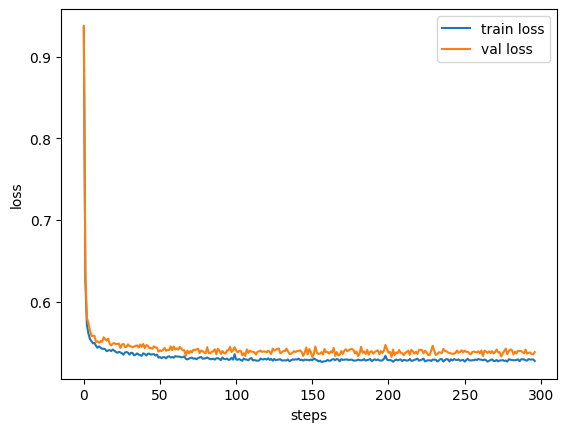

<!-- Optionally, you can display a sample image here if desired -->

## 12. Posterior Sampling

Sample from the posterior distribution using the trained model and visualize the results.

In [27]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=False, rng=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if rng is None:
        rng = jax.random.PRNGKey(42)

    samples = pipeline.sample(rng, observation, nsamples, use_ema=use_ema)
    return samples, true_param, reference_samples

In [28]:
samples, true_param, reference_samples =  get_samples(8)

### Visualize Posterior Samples

Plot the posterior samples as a 2D histogram.

In [29]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

<Figure size 640x480 with 0 Axes>

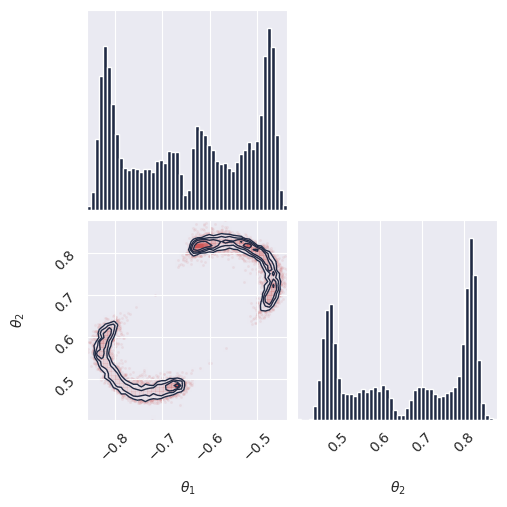

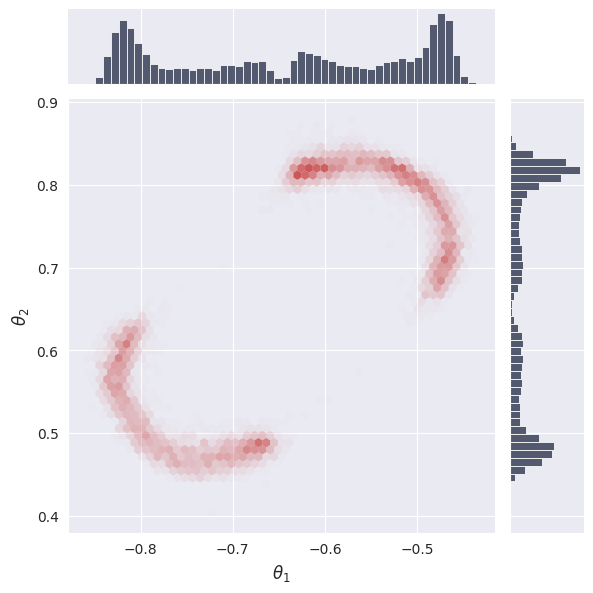

In [30]:
plot_marginals(samples, plot_levels=False, gridsize=50)
plt.show()

plot_marginals(samples, plot_levels=False, gridsize=50, backend="seaborn")
plt.show()

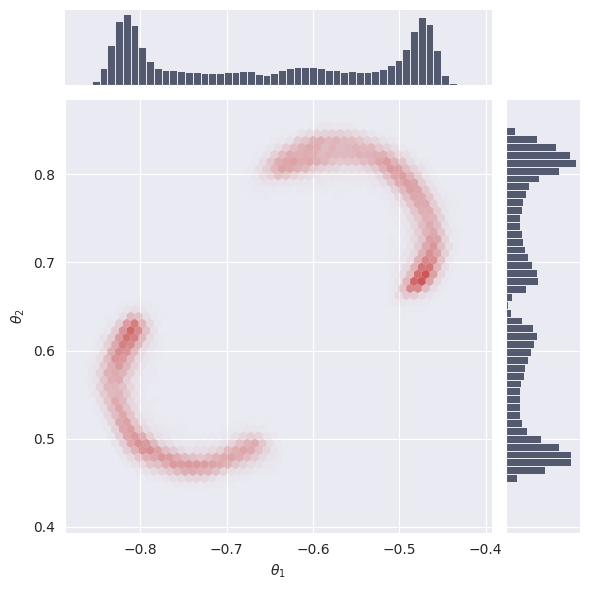

# manual sampling

In [26]:
from gensbi.utils.math import divergence
from jax import Array
from typing import Callable, Optional

from einops import rearrange

In [27]:

class ModelWrapper_old(nnx.Module):
    """
    This class is used to wrap around another model. We define a call method which returns the model output. 
    Furthermore, we define a vector_field method which computes the vector field of the model,
    and a divergence method which computes the divergence of the model, in a form useful for diffrax.
    This is useful for ODE solvers that require the vector field and divergence of the model.

    """

    def __init__(self, model: nnx.Module):
        self.model = model

    def _call_model(self, x: Array, t: Array, args, **kwargs) -> Array:
        r"""
        This method is a wrapper around the model's call method. It allows us to pass additional arguments
        to the model, such as text conditions or other auxiliary information.

        Args:
            x (Array): input data to the model (batch_size, ...).
            t (Array): time (batch_size).
            args: additional information forwarded to the model, e.g., text condition.
            **kwargs: additional keyword arguments.

        Returns:
            Array: model output.
        """
        return self.model(x, t, args=args, **kwargs) # type: ignore

    def __call__(self, x: Array, t: Array, args=None, **kwargs) -> Array:
        r"""
        This method defines how inputs should be passed through the wrapped model.
        Here, we're assuming that the wrapped model takes both :math:`x` and :math:`t` as input,
        along with any additional keyword arguments.

        Optional things to do here:
            - check that t is in the dimensions that the model is expecting.
            - add a custom forward pass logic.
            - call the wrapped model.

        | given x, t
        | returns the model output for input x at time t, with extra information `extra`.

        Args:
            x (Array): input data to the model (batch_size, ...).
            t (Array): time (batch_size).
            **extras: additional information forwarded to the model, e.g., text condition.

        Returns:
            Array: model output.
        """
        return self._call_model(x, t, args, **kwargs)

    def get_vector_field(self, **kwargs) -> Callable:
        r"""Compute the vector field of the model, properly squeezed for the ODE term.

        Args:
            x (Array): input data to the model (batch_size, ...).
            t (Array): time (batch_size).
            args: additional information forwarded to the model, e.g., text condition.

        Returns:
            Array: vector field of the model.
        """
        def vf(t, x, args):
            vf = self._call_model(x, t, args, **kwargs)
            # squeeze the first dimension of the vector field if it is 1
            if vf.shape[0] == 1:
                vf = jnp.squeeze(vf, axis=0)
            return jnp.squeeze(vf, axis=-1)
        return vf
    

    def get_divergence(self, **kwargs) -> Callable:
        r"""Compute the divergence of the model.

        Args:
            t (Array): time (batch_size).
            x (Array): input data to the model (batch_size, ...).
            args: additional information forwarded to the model, e.g., text condition.

        Returns:
            Array: divergence of the model.
        """
        vf = self.get_vector_field(**kwargs)
        def div_(t, x, args):
            div = divergence(vf, t, x, args)
            # squeeze the first dimension of the divergence if it is 1
            if div.shape[0] == 1:
                div = jnp.squeeze(div, axis=0)
            return div

        
        return div_
        

class SimformerConditioner_old(nnx.Module):
    """
    Module to handle conditioning in the Simformer model.

    Args:
        model (Simformer): Simformer model instance.
    """
    def __init__(self, model, dim_joint):
        self.model = model
        self.dim_joint = dim_joint

    def conditioned(
        self, 
        obs: Array, 
        obs_ids: Array, 
        cond: Array, 
        cond_ids: Array, 
        t: Array, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform conditioned inference.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            cond (Array): Conditioning values.
            cond_ids (Array): Conditioning identifiers.
            t (Array): Time steps.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Conditioned output.
        """
        obs = jnp.atleast_1d(obs)
        cond = jnp.atleast_1d(cond)
        t = jnp.atleast_1d(t)

        if obs.ndim < 3:
            obs = rearrange(obs, "... -> 1 ... 1" if obs.ndim == 1 else "... -> ... 1")

        if cond.ndim < 3:
            cond = rearrange(
                cond, "... -> 1 ... 1" if cond.ndim == 1 else "... -> ... 1"
            )
        
        # repeat cond on the first dimension to match obs
        cond = jnp.broadcast_to(
            cond, (obs.shape[0], *cond.shape[1:])
        )

        condition_mask_dim = len(obs_ids) + len(cond_ids)

        condition_mask = jnp.zeros((condition_mask_dim,), dtype=jnp.bool_)
        condition_mask = condition_mask.at[cond_ids].set(True)

        x = jnp.concatenate([obs, cond], axis=1)
        node_ids = jnp.concatenate([obs_ids, cond_ids])

        # Sort the nodes and the corresponding values
        # nodes_sort = jnp.argsort(node_ids)
        # x = x[:, nodes_sort]
        # node_ids = node_ids[nodes_sort]

        res = self.model(
            obs=x,
            t=t,
            node_ids=node_ids,
            condition_mask=condition_mask,
            edge_mask=edge_mask,
        )
        # now return only the values on which we are not conditioning
        res = res[:, :len(obs_ids)]
        # res = jnp.take_along_axis(res, obs_ids, axis=1)
        return res

    def unconditioned(
        self, 
        obs: Array, 
        obs_ids: Array, 
        t: Array, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform unconditioned inference.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            t (Array): Time steps.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Unconditioned output.
        """
        obs = jnp.atleast_1d(obs)
        t = jnp.atleast_1d(t)

        if obs.ndim < 3:
            obs = rearrange(obs, "... -> 1 ... 1" if obs.ndim == 1 else "... -> ... 1")

        condition_mask = jnp.zeros((obs.shape[1],), dtype=jnp.bool_)

        node_ids = obs_ids

        res = self.model(
            obs=obs,
            t=t,
            node_ids=node_ids,
            condition_mask=condition_mask,
            edge_mask=edge_mask,
        )

        return res

    def __call__(
        self, 
        obs: Array, 
        obs_ids: Array, 
        cond: Array, 
        cond_ids: Array, 
        t: Array, 
        conditioned: bool = True, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform inference based on conditioning.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            cond (Array): Conditioning values.
            cond_ids (Array): Conditioning identifiers.
            timesteps (Array): Time steps.
            conditioned (bool): Whether to perform conditioned inference.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Model output.
        """
        if conditioned:
            return self.conditioned(
                obs, obs_ids, cond, cond_ids, t, edge_mask=edge_mask
            )
        else:
            return self.unconditioned(obs, obs_ids, t, edge_mask=edge_mask)


class JointWrapper_old(ModelWrapper_old):
    def __init__(self, model, dim_joint):
        model_conditioned = SimformerConditioner_old(model, dim_joint)
        super().__init__(model_conditioned)

    def _call_model(self, x, t, args, **kwargs):
        return self.model(obs=x, t=t, **kwargs)

In [28]:
from gensbi.utils.model_wrapping import ModelWrapper

@jax.jit
def _expand_dims(x: Array) -> Array:
    x = jnp.atleast_1d(x)
    if x.ndim < 3:
        x = rearrange(x, "... -> 1 ... 1" if x.ndim == 1 else "... -> ... 1")
    return x

@jax.jit
def _expand_time(t: Array) -> Array:
    t = jnp.atleast_1d(t)
    if t.ndim < 2:
        t = t[..., None]
    return t

# class ModelWrapper_new(nnx.Module):
#     """
#     This class is used to wrap around another model. We define a call method which returns the model output.
#     Furthermore, we define a vector_field method which computes the vector field of the model,
#     and a divergence method which computes the divergence of the model, in a form useful for diffrax.
#     This is useful for ODE solvers that require the vector field and divergence of the model.

#     """

#     def __init__(self, model: nnx.Module):
#         self.model = model


#     def __call__(self, t: Array, obs: Array, *args, **kwargs) -> Array:
#         r"""
#         This method defines how inputs should be passed through the wrapped model.
#         Here, we're assuming that the wrapped model takes both :math:`obs` and :math:`t` as input,
#         along with any additional keyword arguments.

#         Optional things to do here:
#             - check that t is in the dimensions that the model is expecting.
#             - add a custom forward pass logic.
#             - call the wrapped model.

#         | given obs, t
#         | returns the model output for input obs at time t, with extra information `extra`.

#         Args:
#             obs (Array): input data to the model (batch_size, ...).
#             t (Array): time (batch_size).
#             **extras: additional information forwarded to the model, e.g., text condition.

#         Returns:
#             Array: model output.
#         """
#         obs = _expand_dims(obs)
#         # t = self._expand_time(t)

#         return self.model(obs, t, *args, **kwargs)

#     def get_vector_field(self, **kwargs) -> Callable:
#         r"""Compute the vector field of the model, properly squeezed for the ODE term.

#         Args:
#             x (Array): input data to the model (batch_size, ...).
#             t (Array): time (batch_size).
#             args: additional information forwarded to the model, e.g., text condition.

#         Returns:
#             Array: vector field of the model.
#         """

#         def vf(t, x, args):
#             # merge args and kwargs
#             args = args if args is not None else {}
#             vf = self(t, x, **args, **kwargs)
#             # squeeze the first dimension of the vector field if it is 1
#             if vf.shape[0] == 1:
#                 vf = jnp.squeeze(vf, axis=0)

#             vf = jnp.squeeze(vf, axis=-1)
#             return vf

#         return vf

#     def get_divergence(self, **kwargs) -> Callable:
#         r"""Compute the divergence of the model.

#         Args:
#             t (Array): time (batch_size).
#             x (Array): input data to the model (batch_size, ...).
#             args: additional information forwarded to the model, e.g., text condition.

#         Returns:
#             Array: divergence of the model.
#         """
#         vf = self.get_vector_field(**kwargs)

#         def div_(t, x, args):
#             div = divergence(vf, t, x, args)
#             # squeeze the first dimension of the divergence if it is 1
#             if div.shape[0] == 1:
#                 div = jnp.squeeze(div, axis=0)
#             return div

#         return div_
    
    

# class SimformerConditioner_new(nnx.Module):
#     """
#     Module to handle conditioning in the Simformer model.

#     Args:
#         model (Simformer): Simformer model instance.
#     """
#     def __init__(self, model, dim_joint):
#         self.model = model
#         self.dim_joint = dim_joint

#     def conditioned(
#         self, 
#         obs: Array, 
#         obs_ids: Array, 
#         cond: Array, 
#         cond_ids: Array, 
#         t: Array, 
#         edge_mask: Optional[Array] = None
#     ) -> Array:
#         """
#         Perform conditioned inference.

#         Args:
#             obs (Array): Observations.
#             obs_ids (Array): Observation identifiers.
#             cond (Array): Conditioning values.
#             cond_ids (Array): Conditioning identifiers.
#             t (Array): Time steps.
#             edge_mask (Optional[Array]): Mask for edges.

#         Returns:
#             Array: Conditioned output.
#         """
#         obs = jnp.atleast_1d(obs)
#         cond = jnp.atleast_1d(cond)
#         t = jnp.atleast_1d(t)

#         if obs.ndim < 3:
#             obs = rearrange(obs, "... -> 1 ... 1" if obs.ndim == 1 else "... -> ... 1")

#         if cond.ndim < 3:
#             cond = rearrange(
#                 cond, "... -> 1 ... 1" if cond.ndim == 1 else "... -> ... 1"
#             )
        
#         # repeat cond on the first dimension to match obs
#         cond = jnp.broadcast_to(
#             cond, (obs.shape[0], *cond.shape[1:])
#         )

#         condition_mask_dim = len(obs_ids) + len(cond_ids)

#         condition_mask = jnp.zeros((condition_mask_dim,), dtype=jnp.bool_)
#         condition_mask = condition_mask.at[cond_ids].set(True)

#         x = jnp.concatenate([obs, cond], axis=1)
#         node_ids = jnp.concatenate([obs_ids, cond_ids])

#         # Sort the nodes and the corresponding values
#         # nodes_sort = jnp.argsort(node_ids)
#         # x = x[:, nodes_sort]
#         # node_ids = node_ids[nodes_sort]

#         res = self.model(
#             obs=x,
#             t=t,
#             node_ids=node_ids,
#             condition_mask=condition_mask,
#             edge_mask=edge_mask,
#         )
#         # now return only the values on which we are not conditioning
#         res = res[:, :len(obs_ids)]
#         # res = jnp.take_along_axis(res, obs_ids, axis=1)
#         return res

#     def unconditioned(
#         self, 
#         obs: Array, 
#         obs_ids: Array, 
#         t: Array, 
#         edge_mask: Optional[Array] = None
#     ) -> Array:
#         """
#         Perform unconditioned inference.

#         Args:
#             obs (Array): Observations.
#             obs_ids (Array): Observation identifiers.
#             t (Array): Time steps.
#             edge_mask (Optional[Array]): Mask for edges.

#         Returns:
#             Array: Unconditioned output.
#         """
#         obs = jnp.atleast_1d(obs)
#         t = jnp.atleast_1d(t)

#         if obs.ndim < 3:
#             obs = rearrange(obs, "... -> 1 ... 1" if obs.ndim == 1 else "... -> ... 1")

#         condition_mask = jnp.zeros((obs.shape[1],), dtype=jnp.bool_)

#         node_ids = obs_ids

#         res = self.model(
#             obs=obs,
#             t=t,
#             node_ids=node_ids,
#             condition_mask=condition_mask,
#             edge_mask=edge_mask,
#         )

#         return res

#     def __call__(
#         self, 
#         t: Array, 
#         obs: Array, 
#         obs_ids: Array, 
#         cond: Array, 
#         cond_ids: Array, 
#         conditioned: bool = True, 
#         edge_mask: Optional[Array] = None
#     ) -> Array:
#         """
#         Perform inference based on conditioning.

#         Args:
#             obs (Array): Observations.
#             obs_ids (Array): Observation identifiers.
#             cond (Array): Conditioning values.
#             cond_ids (Array): Conditioning identifiers.
#             timesteps (Array): Time steps.
#             conditioned (bool): Whether to perform conditioned inference.
#             edge_mask (Optional[Array]): Mask for edges.

#         Returns:
#             Array: Model output.
#         """
#         if conditioned:
#             return self.conditioned(
#                 obs, obs_ids, cond, cond_ids, t, edge_mask=edge_mask
#             )
#         else:
#             return self.unconditioned(obs, obs_ids, t, edge_mask=edge_mask)


# class JointWrapper_new(ModelWrapper_new):
#     def __init__(self, model, dim_joint):
#         model_conditioned = SimformerConditioner_new(model, dim_joint)
#         super().__init__(model_conditioned)
    
#     def __call__(self, t, obs, **kwargs):
#         return self.model(t, obs, **kwargs)

class JointWrapper_new(ModelWrapper):
    """
    Module to handle conditioning in the Simformer model.

    Args:
        model (Simformer): Simformer model instance.
    """
    def __init__(self, model, dim_joint):
        super().__init__(model)
        self.dim_joint = dim_joint

    def conditioned(
        self, 
        obs: Array, 
        obs_ids: Array, 
        cond: Array, 
        cond_ids: Array, 
        t: Array, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform conditioned inference.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            cond (Array): Conditioning values.
            cond_ids (Array): Conditioning identifiers.
            t (Array): Time steps.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Conditioned output.
        """
        
        obs_dim = obs.shape[1]
        cond_dim = cond.shape[1]
        # repeat cond on the first dimension to match obs
        cond = jnp.broadcast_to(
            cond, (obs.shape[0], *cond.shape[1:])
        )

        condition_mask_dim = obs_dim + cond_dim

        condition_mask = jnp.zeros((condition_mask_dim,), dtype=jnp.bool_)
        condition_mask = condition_mask.at[obs_dim:].set(True)

        x = jnp.concatenate([obs, cond], axis=1)
        node_ids = jnp.concatenate([obs_ids, cond_ids])

        res = self.model(
            obs=x,
            t=t,
            node_ids=node_ids,
            condition_mask=condition_mask,
            edge_mask=edge_mask,
        )
        # now return only the values on which we are not conditioning
        res = res[:, :obs_dim]
        return res

    def unconditioned(
        self, 
        obs: Array, 
        obs_ids: Array, 
        t: Array, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform unconditioned inference.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            t (Array): Time steps.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Unconditioned output.
        """

        condition_mask = jnp.zeros((obs.shape[1],), dtype=jnp.bool_)

        node_ids = obs_ids

        res = self.model(
            obs=obs,
            t=t,
            node_ids=node_ids,
            condition_mask=condition_mask,
            edge_mask=edge_mask,
        )

        return res

    def __call__(
        self, 
        t: Array, 
        obs: Array, 
        obs_ids: Array, 
        cond: Array, 
        cond_ids: Array, 
        conditioned: bool = True, 
        edge_mask: Optional[Array] = None
    ) -> Array:
        """
        Perform inference based on conditioning.

        Args:
            obs (Array): Observations.
            obs_ids (Array): Observation identifiers.
            cond (Array): Conditioning values.
            cond_ids (Array): Conditioning identifiers.
            timesteps (Array): Time steps.
            conditioned (bool): Whether to perform conditioned inference.
            edge_mask (Optional[Array]): Mask for edges.

        Returns:
            Array: Model output.
        """
        t = _expand_time(t)
        obs = _expand_dims(obs)
        cond = _expand_dims(cond)
        
        if conditioned:
            return self.conditioned(
                obs, obs_ids, cond, cond_ids, t, edge_mask=edge_mask
            )
        else:
            return self.unconditioned(obs, obs_ids, t, edge_mask=edge_mask)


# class JointWrapper_new(ModelWrapper_new):
#     def __init__(self, model, dim_joint):
#         model_conditioned = SimformerConditioner_new(model, dim_joint)
#         super().__init__(model_conditioned)
    
#     def __call__(self, t, obs, **kwargs):
#         return self.model(t, obs, **kwargs)

In [29]:
vf_wrapped_old = JointWrapper_old(pipeline.model, dim_joint)
vf_wrapped_new = JointWrapper_new(pipeline.model, dim_joint)

## test vector field

In [30]:
idx=1
observation, reference_samples =  task.get_reference(idx)
true_param = jnp.array(task.get_true_parameters(idx))
obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])

rng = jax.random.PRNGKey(45)

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_obs)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (1, dim_cond, 1)) # n, dim_obs, 1

model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": None}

In [31]:
vf_old = vf_wrapped_old.get_vector_field(**model_extras)

In [32]:
x = jax.random.normal(jax.random.PRNGKey(0),(10, dim_obs))
t = jnp.ones((10,))*0.5

In [33]:
old_val = vf_old(t,x,None)

In [34]:
vf_new = vf_wrapped_new.get_vector_field(**model_extras)

In [35]:
new_val = vf_new(t,x,None)

In [36]:
jnp.allclose(old_val, new_val)

Array(True, dtype=bool)

## test sampling

In [ ]:

from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver

In [ ]:
obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
step_size = 0.01

In [ ]:
def get_samples_old(vf_wrapped, idx, nsamples=10_000, edge_mask=None):
    observation, reference_samples =  task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    rng = jax.random.PRNGKey(45)

    key1,key2 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_obs)) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (1, dim_cond, 1)) # n, dim_obs, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": edge_mask}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

In [ ]:
samples_old, true_param, reference_samples = get_samples_old(vf_wrapped_old, 8)

In [ ]:
plot_marginals(samples_old, plot_levels=False, gridsize=100, range=[(-1.,1.),(-1.,1.)], backend="seaborn")
plt.show()